# **Practical session on Transfer Learning**
This Pratical session proposes to study several techniques for improving challenging context, in which few data and resources are available.

# Introduction

**Context :**

Assume we are in a context where few "gold" labeled data are available for training, say 

$$\mathcal{X}_{\text{train}} = \{(x_n,y_n)\}_{n\leq N_{\text{train}}}$$

where $N_{\text{train}}$ is small. 

A large test set $\mathcal{X}_{\text{test}}$ as well as a large amount of unlabeled data, $\mathcal{X}$, is available. We also assume that we have a limited computational budget (e.g., no GPUs).

**Instructions to follow :** 

For each question, write a commented *Code* or a complete answer as a *Markdown*. When the objective of a question is to report a CNN accuracy, please use the following format to report it, at the end of the question :

| Model | Number of  epochs  | Train accuracy | Test accuracy |
|------|------|------|------|
|   XXX  | XXX | XXX | XXX |

If applicable, please add the field corresponding to the  __Accuracy on Full Data__ as well as a link to the __Reference paper__ you used to report those numbers. (You do not need to train a CNN on the full CIFAR10 dataset!)

In your final report, please *keep the logs of each training procedure* you used. We will only run this jupyter if we have some doubts on your implementation. 

The total file sizes should be reasonable (feasible with 2MB only!). You will be asked to hand in the notebook, together with any necessary files required to run it if any.

You can use https://colab.research.google.com/ to run your experiments.

## Training set creation
__Question 1 (2 points) :__ Propose a dataloader to obtain a training loader that will only use the first 100 samples of the CIFAR-10 training set.

Additional information :  

*   CIFAR10 dataset : https://en.wikipedia.org/wiki/CIFAR-10
*   You can directly use the dataloader framework from Pytorch.
*   Alternatively you can modify the file : https://github.com/pytorch/vision/blob/master/torchvision/datasets/cifar.py

In [1]:
# Importing dependencies 
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader, Subset 
import numpy as np

cifar_training_dataset = CIFAR10(root = './data', train = True, download = True)
train_100 = Subset(cifar_training_dataset, np.arange(100))
train_dataloder = DataLoader(train_100)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data


* This is our dataset $\mathcal{X}_{\text{train}}$, it will be used until the end of this project. 

* The remaining samples correspond to $\mathcal{X}$. 

* The testing set $\mathcal{X}_{\text{test}}$ corresponds to the whole testing set of CIFAR-10.

## Testing procedure
__Question 2 (1.5 points):__ Explain why the evaluation of the training procedure is difficult. Propose several solutions.

Many problems are related to the construction of the training set. The first problem is that the dataset is small, which increases the likelihood of the model overfitting and performing poorly on a larger test set. Another issue is that there may be class imbalance or even classes that were not represented in the training set, which can lead to biased evaluation of the model's performance.

To alleviate these problems, several techniques can be employed, such as weak supervision techniques like transfer learning and active learning. Data augmentation can also be used to improve the training set by generating additional data, and a stratified approach can be taken to ensure class balance.

# The Baseline

In this section, the goal is to train a CNN on $\mathcal{X}_{\text{train}}$ and compare its performance with reported numbers from the litterature. You will have to re-use and/or design a standard classification pipeline. You should optimize your pipeline to obtain the best performances (image size, data augmentation by flip, ...).

The key ingredients for training a CNN are the batch size, as well as the learning rate scheduler (i.e. how to decrease the learning rate as a function of the number of epochs). A possible scheduler is to start the learning rate at 0.1 and decreasing it every 30 epochs by 10. In case of divergence, reduce the learning rate. A potential batch size could be 10, yet this can be cross-validated.

You can get some baselines accuracies in this paper (obviously, it is a different context for those researchers who had access to GPUs!) : http://openaccess.thecvf.com/content_cvpr_2018/papers/Keshari_Learning_Structure_and_CVPR_2018_paper.pdf. 

## ResNet architectures

__Question 3 (4 points) :__ Write a classification pipeline for $\mathcal{X}_{\text{train}}$, train from scratch and evaluate a *ResNet-18* architecture specific to CIFAR10 (details about the ImageNet model can be found here: https://arxiv.org/abs/1512.03385). Please report the accuracy obtained on the whole dataset as well as the reference paper/GitHub link.

*Hint :* You can re-use the following code : https://github.com/kuangliu/pytorch-cifar. During a training of 10 epochs, a batch size of 10 and a learning rate of 0.01, one obtains 40% accuracy on $\mathcal{X}_{\text{train}}$ (\~2 minutes) and 20% accuracy on $\mathcal{X}_{\text{test}}$ (\~5 minutes).

In [2]:
# As suggested the following code is a re use of from the giving link:https://github.com/kuangliu/pytorch-cifar

import torch
import torch.nn as nn
import torch.nn.functional as F


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])

In [3]:
# let's define a function to train the model 
import torch
device = torch.device('cuda') if torch.cuda.is_available() else 'cpu'

In [4]:
def train(model, optimizer, criterion,scheduler, dataLoader, epochs, verbose = True ,verbose_fraq = 5, device = device):
  model = model.to(device)
  history_loss = []
  history_accuracy = []

  for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    epoch_num_samples = 0
    epoch_correct = 0

    for batch_idx, (x_batch, y_batch) in enumerate(dataLoader):
      x_batch, y_batch = x_batch.to(device), y_batch.to(device)
      optimizer.zero_grad()
      output = model(x_batch)
      loss = criterion(output, y_batch)
      loss.backward()
      optimizer.step()
      
      y_predicted = output.argmax(dim = 1)
      epoch_loss += loss.item()
      epoch_num_samples += len(y_batch)
      epoch_correct += (y_predicted == y_batch).sum()

    epoch_accuracy = 100 * epoch_correct.item() / epoch_num_samples
    history_accuracy.append(round(epoch_accuracy ,2))
    epoch_loss = round(epoch_loss / len(dataLoader),2)
    history_loss.append(epoch_loss)

    scheduler.step() # Adjust scheduler

    if verbose:
      if epoch % verbose_fraq == 0:
        print(f'Train Epoch: {epoch} : Loss : {epoch_loss} / Accuracy : {epoch_accuracy} %')
  return history_loss, history_accuracy

In [5]:
# now let's define a function to test the model 
def test(model, dataLoader, device = device):
  model.eval()
  num_samples = 0
  correct = 0
  for batch_idx, (x_batch, y_batch) in enumerate(dataLoader):
    x_batch, y_batch = x_batch.to(device), y_batch.to(device)
    output = model(x_batch)
    predict = output.argmax(dim = 1)
    num_samples += len(y_batch)
    correct += (predict == y_batch).sum()
  return round(100 * correct.item() / num_samples, 2)


In [6]:
# Let's start training 
import torchvision.transforms as transforms

epochs = 20
batch_size = 10

In [7]:
# define train loader 
cifar_training_dataset = CIFAR10(root = './conent', train = True, download = True, transform=transforms.ToTensor())
train_100 = Subset(cifar_training_dataset, np.arange(100))
train_dataloder = DataLoader(train_100, batch_size= batch_size, shuffle = True)
# define test loader 
cifar_test_dataset = CIFAR10(root = './conent', train = False, download = True, transform=transforms.ToTensor())
test_dataloder = DataLoader(cifar_test_dataset, batch_size= batch_size)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./conent/cifar-10-python.tar.gz to ./conent
Files already downloaded and verified


In [ ]:
# define the model

resnet = ResNet18()
optimizer = torch.optim.SGD(resnet.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 5, gamma = 0.1)
criterion = nn.CrossEntropyLoss()


print(" Start training " + "."*20)
train_accuracy , training_loss = train(resnet, optimizer, criterion,scheduler, train_dataloder, epochs, verbose = True ,verbose_fraq = 5, device = device)

 Start training ....................
Train Epoch: 0 : Loss : 2.37 / Accuracy : 14.0 %
Train Epoch: 5 : Loss : 0.47 / Accuracy : 95.0 %
Train Epoch: 10 : Loss : 0.31 / Accuracy : 100.0 %
Train Epoch: 15 : Loss : 0.23 / Accuracy : 100.0 %


In [ ]:
# Now let's test our model 
print("Tesing the model" + '.'*20)
test_accuracy = test(resnet, test_dataloder, device = device)
print(f"test_accuracy is {test_accuracy} %")

Tesing the model....................
test_accuracy is 22.64 %


| Model | Number of  epochs  | Train accuracy | Test accuracy |
|------|------|------|------|
|   ResNet18 (100 samples)  | 20 | 100% | 22.64 % |


Compared to ResNet18 models with different epochs and trained on the whole training set :

|Link | Model | Number of  epochs  | Train accuracy | Test accuracy |
|-----|------|------|------|------|
|  https://github.com/Mountchicken/ResNet18-CIFAR10 |ResNet18 | 300 | -- | 95.09 % |
|   https://github.com/abhisikdar/RESNET18-CIFAR10/blob/main/Part_1.ipynb|ResNet18 | 100 | 100% | 75.8 % |

# Transfer learning

We propose to use pre-trained models on a classification and generative task, in order to improve the results of our setting.

## ImageNet features

Now, we will use some pre-trained models on ImageNet and see how well they compare on CIFAR. A list is available on : https://pytorch.org/vision/stable/models.html.

__Question 4 (3 points):__ Pick a model from the list above, adapt it for CIFAR10 and retrain its final layer (or a block of layers, depending on the resources to which you have access to). Report its accuracy.

In [8]:
from torchvision.models import resnet50

In [9]:
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [10]:
# For this part we picked a ResNet50 model let's fine tune it as suggested in the course, in the first part we only train the last add layer and freeze all the other layers,
# and in a second time we are going to unfreeze all the layers and retrain  the whole layers 

class ResNet50_pretrained(nn.Module):
  def __init__(self):
    super(ResNet50_pretrained, self).__init__()
    self.pretrained_model = resnet50(pretrained = True)
    self.features = nn.Sequential(*list(self.pretrained_model.children())[:-1])
    self.fc = nn.Linear(self.pretrained_model.fc.in_features, 10)

  def forward(self, x):
    x = self.features(x)
    # let's squeeze it 
    x = x.squeeze(3).squeeze(2)
    x = self.fc(x)
    return x

In [11]:
# Let's now define a function for the training strategy 
def train_pretrained_model( train_loader,test_loader ,epochs, verbose = True ,verbose_fraq = 5, device = device, plot_res = True, test_model = True):
  model = ResNet50_pretrained()
  optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
  scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 20, gamma = 0.2)
  criterion = nn.CrossEntropyLoss()

  for param in model.parameters():
    param.requires_grad = False
  for param in model.fc.parameters():
    param.requires_grad = True 
  
  print("Start first stage of training " + '.'*50)
  training_loss1, train_accuracy1 = train(model, optimizer, criterion,scheduler, train_dataloder, epochs, verbose = True ,verbose_fraq = 5, device = device)
  test_accuracy = test(model , test_dataloder, device = device)
  print(f"test_accuracy after first stage is {test_accuracy} %")

  print("Start second stage of training " + '.'*50)
  for param in model.parameters():
    param.requires_grad = True

  training_loss2, train_accuracy2  = train(model, optimizer, criterion,scheduler, train_dataloder, epochs, verbose = True ,verbose_fraq = 5, device = device)
  if test_model:
    test_accuracy = test(model , test_dataloder, device = device)
    print(f"test_accuracy after second stage is {test_accuracy} %")
  if plot_res :
    # let's plot the history of loss and accuracy functions
    fig, axes = plt.subplots(1,2, figsize = (10,10))
    axes[0].plot(np.arange(1,epochs+1), train_accuracy1, label = 'First stage')
    axes[0].plot(np.arange(epochs+1,2 * epochs+1), train_accuracy2, label = 'Second stage')
    axes[0].set_title('Training Accuracy')
    axes[0].set_xlabel('epochs')

    axes[1].plot(np.arange(1,epochs+1), training_loss1, label = 'First stage')
    axes[1].plot(np.arange(epochs+1,2 * epochs+1), training_loss2, label = 'Second stage')
    axes[1].set_title('Training Loss')
    axes[1].set_xlabel('epochs')
    fig.show()

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

Start first stage of training ..................................................
Train Epoch: 0 : Loss : 17.91 / Accuracy : 9.0 %
Train Epoch: 5 : Loss : 8.67 / Accuracy : 24.0 %
Train Epoch: 10 : Loss : 4.92 / Accuracy : 44.0 %
Train Epoch: 15 : Loss : 3.18 / Accuracy : 50.0 %
Train Epoch: 20 : Loss : 1.7 / Accuracy : 73.0 %
Train Epoch: 25 : Loss : 1.02 / Accuracy : 80.0 %
Train Epoch: 30 : Loss : 1.47 / Accuracy : 78.0 %
Train Epoch: 35 : Loss : 1.24 / Accuracy : 73.0 %
Train Epoch: 40 : Loss : 0.81 / Accuracy : 80.0 %
Train Epoch: 45 : Loss : 0.68 / Accuracy : 83.0 %
Train Epoch: 50 : Loss : 0.81 / Accuracy : 84.0 %
Train Epoch: 55 : Loss : 0.92 / Accuracy : 82.0 %
test_accuracy after first stage is 21.39 %
Start second stage of training ..................................................
Train Epoch: 0 : Loss : 9.58 / Accuracy : 30.0 %
Train Epoch: 5 : Loss : 1.69 / Accuracy : 48.0 %
Train Epoch: 10 : Loss : 1.17 / Accuracy : 64.0 %
Train Epoch: 15 : Loss : 0.92 / Accuracy : 72.0 %

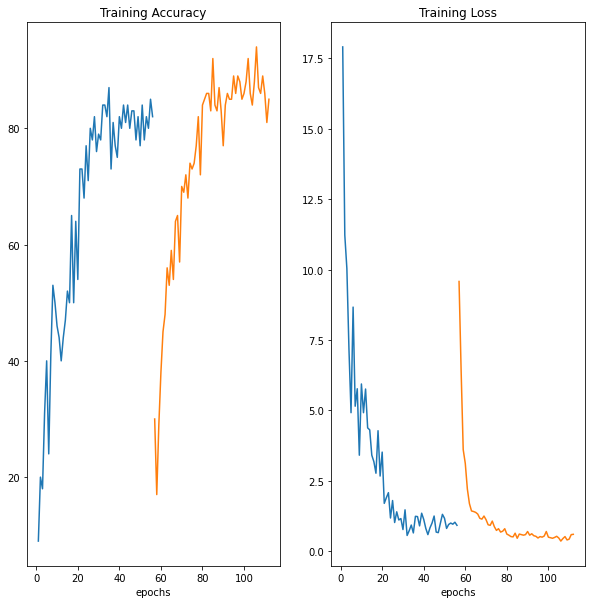

In [12]:
# let's use 31 epochs for each phase 
epochs = 56
train_pretrained_model( train_dataloder,test_dataloder ,epochs, verbose = True ,verbose_fraq = 5, device = device)

We can see a drop in the accuracy in the beginning of the second phase followed by an increasing phase.

| Model | Number of  epochs  | Train accuracy | Test accuracy |
|------|------|------|------|
|   ResNet50 (only last layer is trained)  | 55 | 85% | 22.23 % |
|   ResNet50 (two training phases)  | 55 + 55 | 90 % | 24.68 % |

We need to resize the images to 224*224 like the training of ResNet50 was done 

In [ ]:
# In order to benifite from the way ResNet50 was trained, it would be a good practice to resize the image to that format
from torchvision.transforms import transforms
batch_size = 10

transformations = transforms.Compose([
                transforms.Resize((224,224)),
                transforms.ToTensor()
                ])

# define train loader 
cifar_training_dataset = CIFAR10(root = './conent', train = True, download = True, transform=transformations)
train_100 = Subset(cifar_training_dataset, np.arange(100))
train_dataloder = DataLoader(train_100, batch_size= batch_size, shuffle = True)
# define test loader 
cifar_test_dataset = CIFAR10(root = './conent', train = False, download = True, transform=transformations)
test_dataloder = DataLoader(cifar_test_dataset, batch_size= batch_size)

Files already downloaded and verified
Files already downloaded and verified


Start first stage of training ..................................................
Train Epoch: 0 : Loss : 12.77 / Accuracy : 12.0 %
Train Epoch: 5 : Loss : 3.97 / Accuracy : 55.0 %
Train Epoch: 10 : Loss : 0.86 / Accuracy : 83.0 %
Train Epoch: 15 : Loss : 0.15 / Accuracy : 95.0 %
Train Epoch: 20 : Loss : 0.03 / Accuracy : 98.0 %
Train Epoch: 25 : Loss : 0.01 / Accuracy : 100.0 %
Train Epoch: 30 : Loss : 0.02 / Accuracy : 100.0 %
Train Epoch: 35 : Loss : 0.11 / Accuracy : 97.0 %
Train Epoch: 40 : Loss : 0.02 / Accuracy : 99.0 %
Train Epoch: 45 : Loss : 0.04 / Accuracy : 99.0 %
Train Epoch: 50 : Loss : 0.05 / Accuracy : 99.0 %
test_accuracy after first stage is 53.46 %
Start second stage of training ..................................................
Train Epoch: 0 : Loss : 0.09 / Accuracy : 97.0 %
Train Epoch: 5 : Loss : 0.08 / Accuracy : 98.0 %
Train Epoch: 10 : Loss : 0.01 / Accuracy : 100.0 %
Train Epoch: 15 : Loss : 0.0 / Accuracy : 100.0 %
Train Epoch: 20 : Loss : 0.01 / Accuracy : 1

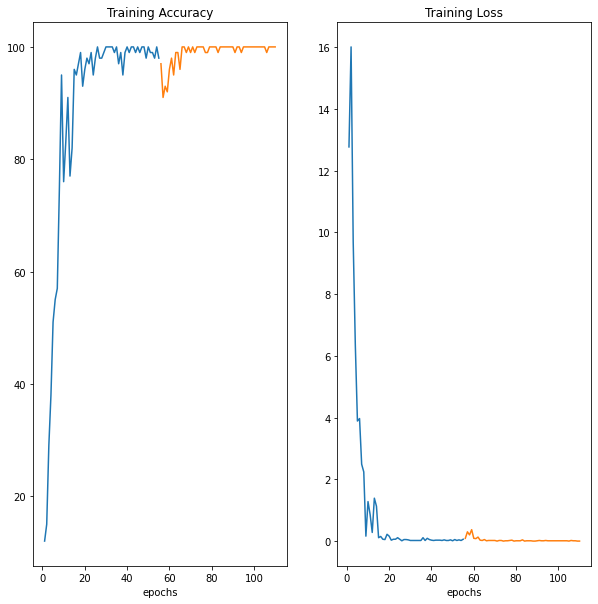

In [ ]:
epochs = 55
train_pretrained_model( train_dataloder,test_dataloder ,epochs, verbose = True ,verbose_fraq = 5, device = device)

We can see that the accuracy is constantly increasing even at the start of the second phase, we can also observe that the number of epochs needed is smaller than for the previous case.

| Model | Number of  epochs  | Train accuracy | Test accuracy |
|------|------|------|------|
|   ResNet50 (only last layer is trained)  | 55 | 99% | 53.46 % |
|   ResNet50 (two training phases)  | 55 + 55 | 100 % | 54.38 % |

We need to resize the images to 224*224 like the training of ResNet50 was done 

# Incorporating *a priori*
Geometrical *a priori* are appealing for image classification tasks. For now, we only consider linear transformations $\mathcal{T}$ of the inputs $x:\mathbb{S}^2\rightarrow\mathbb{R}$ where $\mathbb{S}$ is the support of an image, meaning that :

$$\forall u\in\mathbb{S}^2,\mathcal{T}(\lambda x+\mu y)(u)=\lambda \mathcal{T}(x)(u)+\mu \mathcal{T}(y)(u)\,.$$

For instance if an image had an infinite support, a translation $\mathcal{T}_a$ by $a$ would lead to :

$$\forall u, \mathcal{T}_a(x)(u)=x(u-a)\,.$$

Otherwise, one has to handle several boundary effects.

__Question 5 (1.5 points) :__ Explain the issues when dealing with translations, rotations, scaling effects, color changes on $32\times32$ images. Propose several ideas to tackle them.

* **Translation, rotation and scalling :** When applying these transformations, many issues will araise, starting from information loss ( for example when the resulted pixel's transformation lay outside of the image boundary). The second problem is distortion (e.g the change in the shape of the objects in the image). Another problem related to scalling is blurring effect due to change in the original dimensions of the image.
To mitigate these problems, we can use padding, interpolation/resampling techniques such as bilinear interpolation or bicubic interpolation 
* **Color changes :** the main problem is the correlation between colors and intensities (it is the case for RGB space) which affect the perceived brightness and contrast of the image, making it harder to distinguish between different elements in the image. So solve this problem we can use several techniques as histogram equalization, contrast stretching, and color balance adjustment or samply change the color space to HSV.

## Data augmentations

__Question 6 (3 points):__ Propose a set of geometric transformation beyond translation, and incorporate them in your training pipeline. Train the model of the __Question 3__ with them and report the accuracies.

For this question we are going to use `ColorJitter`, to randomly change the brightness, contrast, saturation and hue of an image. `RandomHorizontalFlip` to horizontally flip the given image randomly with a given probability, and `RandomRotation` to rotate the image by angle.

In [ ]:
# Data transformations
transformations = transforms.Compose([
                 transforms.ColorJitter(hue= 0.1),
                 transforms.RandomHorizontalFlip(),
                 transforms.RandomRotation(degrees = (0, 180)),
                 transforms.ToTensor(),
                 transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)), # these values are obtained from google 
                 ])


# define train loader 
cifar_training_dataset = CIFAR10(root = './conent', train = True, download = True, transform=transformations)
train_100 = Subset(cifar_training_dataset, np.arange(100))
train_dataloder = DataLoader(train_100, batch_size= 2 * batch_size, shuffle = True)
# define test loader 
cifar_test_dataset = CIFAR10(root = './conent', train = False, download = True, transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))]))
test_dataloder = DataLoader(cifar_test_dataset, batch_size= 2*batch_size)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
# define the model

resnet = ResNet18()
optimizer = torch.optim.SGD(resnet.parameters(), lr=0.05)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 16, gamma = 0.5)
criterion = nn.CrossEntropyLoss()

epochs = 76

print(" Start training " + "."*20)
train_accuracy , training_loss = train(resnet, optimizer, criterion,scheduler, train_dataloder, epochs, verbose = True ,verbose_fraq = 5, device = device)

 Start training ....................
Train Epoch: 0 : Loss : 3.81 / Accuracy : 14.0 %
Train Epoch: 5 : Loss : 2.11 / Accuracy : 28.0 %
Train Epoch: 10 : Loss : 2.26 / Accuracy : 23.0 %
Train Epoch: 15 : Loss : 1.85 / Accuracy : 37.0 %
Train Epoch: 20 : Loss : 1.42 / Accuracy : 54.0 %
Train Epoch: 25 : Loss : 1.28 / Accuracy : 51.0 %
Train Epoch: 30 : Loss : 0.96 / Accuracy : 58.0 %
Train Epoch: 35 : Loss : 0.73 / Accuracy : 76.0 %
Train Epoch: 40 : Loss : 0.57 / Accuracy : 81.0 %
Train Epoch: 45 : Loss : 0.49 / Accuracy : 81.0 %
Train Epoch: 50 : Loss : 0.42 / Accuracy : 88.0 %
Train Epoch: 55 : Loss : 0.41 / Accuracy : 87.0 %
Train Epoch: 60 : Loss : 0.29 / Accuracy : 90.0 %
Train Epoch: 65 : Loss : 0.32 / Accuracy : 93.0 %
Train Epoch: 70 : Loss : 0.21 / Accuracy : 94.0 %
Train Epoch: 75 : Loss : 0.17 / Accuracy : 98.0 %


In [ ]:
# Now let's test our model 
print("Tesing the model" + '.'*20)
test_accuracy = test(resnet, test_dataloder, device = device)
print(f"test_accuracy is {test_accuracy} %")

Tesing the model....................
test_accuracy is 21.7 %


| Model | Number of  epochs  | Train accuracy | Test accuracy |
|------|------|------|------|
|   ResNet18 (augmented samples)  | 76 | 98% | 21.7 % |

# Conclusions

__Question 7 (5 points) :__ Write a short report explaining the pros and the cons of each method that you implemented. 25% of the grade of this project will correspond to this question, thus, it should be done carefully. In particular, please add a plot that will summarize all your numerical results.

The goal of this project is to learn how to deal with data scarcity problem. We were giving a dataset of 100 samples and the task is to build a model that will classify 32*32 images into 10 different classes. 

The naive idea is to use only these 100 samples, in a second time we used a pre-trained model and we fine tune it to better fit the giving task.In a final approach, we used data augmentation techniques. Following is a more details discussion about all the steps.

The main problem with training with small data is overfitting, we can notice this in all the tested algorithms, we notice that all the training accuracies were greater than 90%.

The first tested solution is **Transfer Learning**, for this purpose we followed the same approch as in the course, in a first stage we freezed all the pre-trained part and only train the additional dense layer, and in a second time we trained the whole architecture. the **pros** of this approach is the high increase in performances, mitigate the effect of small train dataset and also accelerate the convergence and reduce the training time compared to the case where the whole architecture was trained from scratch. Howerer, some of the **cons** of this approach is their limited flexibility, the pretrained model was build on a similar but yet a different task, the second problem related to this approch is the fact that the model still overfitts and transfer learning in general can also make interpretation more difficult.

The second solution is **Data augmentation** , where the idea is to apply some transformations to the original images in order to build a new trainset with more samples. The main **cons** of this approach is that the constructed datase might not change very much from the original samples and thus the algorithm will see the same sample many times and thus increase the likelihood of overfitting. The other problem is that the augmented images might not represent the reality. However, this method have some **pros**, when the transformations are carefully selected, as it increases the data diversity and improve the model robustness by creating images under different conditions.  

Bellow is a plot of all the results found so far by these tests: 

| Model | Number of  epochs  | Train accuracy | Test accuracy |
|------|------|------|------|
|   ResNet18 (100 samples)  | 20 | 100% | 22.64 % |
|   ResNet18 (augmented samples)  | 76 | 98% | 21.7 % |
|   ResNet50 (only last layer is trained)  | 55 | 85% | 22.23 % |
|   ResNet50 (two training phases)  | 55 + 55 | 90 % | 24.68 % |
|   ResNet50 ( resized + only last layer is trained)  | 55 | 99% | 53.46 % |
|   ResNet50 (resized + two training phases)  | 55 + 55 | 100 % | 54.38 % |

**Conclusion :** The best found method is transfer learning on ResNet50 with a resizing transformation. It is worth nothing that testing tranfer learning on other models, or using other data augmentation techniques might lead to better performances than the ones reported.


# Weak supervision

__Bonus \[open\] question (up to 3 points) :__ Pick a weakly supervised method that will potentially use $\mathcal{X}\cup\mathcal{X}_{\text{train}}$ to train a representation (a subset of $\mathcal{X}$ is also fine). Evaluate it and report the accuracies. You should be careful in the choice of your method, in order to avoid heavy computational effort.

For this part, we choosed to use `Uncertainty sampling`. The idea behind this method is to train the model and then predict the classes on unseen data, and ask the programmer to labelize the data for which the model was the most uncertain, we then merge these samples with the original trainset and re train the model. We are going to iteratively do so and print the evolution of the model's performance on the test dataset and report the results on a graph.

For computaional resources reason, we choosed at each iteration to labelize 10 more samples until having 1000 training samples in total. Since the transfer learning solution showed the best results, we are going to use it as our predictive model.

In [ ]:
# Let's now define a function for the training strategy 
def train_pretrained_model(model, train_loader,test_loader ,epochs, verbose = True ,verbose_fraq = 5, device = device, plot_res = True, test_model = True):
  
  optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
  scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 20, gamma = 0.2)
  criterion = nn.CrossEntropyLoss()

  for param in model.parameters():
    param.requires_grad = False
  for param in model.fc.parameters():
    param.requires_grad = True 
  
  print("Start first stage of training " + '.'*50)
  training_loss1, train_accuracy1 = train(model, optimizer, criterion,scheduler, train_dataloder, epochs, verbose = False ,verbose_fraq = 5, device = device)
  if test_model:
    test_accuracy = test(model , test_dataloder, device = device)
    print(f"test_accuracy after first stage is {test_accuracy} %")

  print("Start second stage of training " + '.'*50)
  for param in model.parameters():
    param.requires_grad = True

  training_loss2, train_accuracy2  = train(model, optimizer, criterion,scheduler, train_dataloder, epochs, verbose = False ,verbose_fraq = 5, device = device)
  if test_model:
    test_accuracy = test(model , test_dataloder, device = device)
    print(f"test_accuracy after second stage is {test_accuracy} %")
  if plot_res :
    # let's plot the history of loss and accuracy functions
    fig, axes = plt.subplots(1,2, figsize = (10,10))
    axes[0].plot(np.arange(1,epochs+1), train_accuracy1, label = 'First stage')
    axes[0].plot(np.arange(epochs+1,2 * epochs+1), train_accuracy2, label = 'Second stage')
    axes[0].set_title('Training Accuracy')
    axes[0].set_xlabel('epochs')

    axes[1].plot(np.arange(1,epochs+1), training_loss1, label = 'First stage')
    axes[1].plot(np.arange(epochs+1,2 * epochs+1), training_loss2, label = 'Second stage')
    axes[1].set_title('Training Loss')
    axes[1].set_xlabel('epochs')
    fig.show()

In [ ]:
# now let's define a function to test the model 
def test(model, dataLoader, device = device):
  model.eval()
  predicted = []
  correct = 0
  num_samples = 0
  for batch_idx, (x_batch, y_batch) in enumerate(dataLoader):
    x_batch, y_batch = x_batch.to(device), y_batch.to(device)
    output = model(x_batch)
    predict = F.softmax(output, dim = 1) # Since softmax is 
    predict2 = output.argmax(dim = 1)
    num_samples += len(y_batch)
    correct += (predict2 == y_batch).sum()
    
    predicted += list(predict.detach().cpu().numpy())
  return predicted,round(100 * correct.item() / num_samples, 2)

In [ ]:
from tqdm import tqdm

In [ ]:
# define train loader 
batch_size = 20 
epochs = 20

cifar_training_dataset = CIFAR10(root = './conent', train = True, download = True, transform=transforms.ToTensor())
cifar_training_dataset = Subset(cifar_training_dataset, np.arange(1000))

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./conent/cifar-10-python.tar.gz to ./conent


In [ ]:
training_index = [i for i in range(100)]
testing_index_set = [ i for i in range(100, 1000)]
testing_accuracies = []
for i in tqdm(range(90)):
  train_iter = Subset(cifar_training_dataset, training_index)
  train_dataloder = DataLoader(train_iter, batch_size= batch_size, shuffle = False)

  test_iter = Subset(cifar_training_dataset, testing_index_set)
  test_dataloder = DataLoader(test_iter, batch_size= batch_size, shuffle = False) 

  model = ResNet50_pretrained()
  print('Start Training ' + '-'*50)
  train_pretrained_model(model, train_dataloder,test_dataloder ,epochs, verbose = False ,verbose_fraq = 5, plot_res = False, test_model = False)
  print('Start Testing ' + '-'*50)
  predicted, acc = test(model, test_dataloder)
  testing_accuracies.append(acc)
  # now let's find the most uncertain points 
  predicted = np.max(predicted, axis = 1)
  sorted_args = np.argsort(predicted)
  new_index = [testing_index_set[x] for x in sorted_args[:10]]
  for index in new_index:
    testing_index_set.remove(index)
    training_index.append(index)

  0%|          | 0/90 [00:00<?, ?it/s]Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

Start Training --------------------------------------------------
Start first stage of training ..................................................
Start second stage of training ..................................................
Start Testing --------------------------------------------------


  1%|          | 1/90 [00:19<29:37, 19.97s/it]

Start Training --------------------------------------------------
Start first stage of training ..................................................
Start second stage of training ..................................................
Start Testing --------------------------------------------------


  2%|▏         | 2/90 [00:26<18:06, 12.34s/it]

Start Training --------------------------------------------------
Start first stage of training ..................................................
Start second stage of training ..................................................
Start Testing --------------------------------------------------


  3%|▎         | 3/90 [00:33<13:51,  9.56s/it]

Start Training --------------------------------------------------
Start first stage of training ..................................................
Start second stage of training ..................................................
Start Testing --------------------------------------------------


  4%|▍         | 4/90 [00:40<12:41,  8.85s/it]

Start Training --------------------------------------------------
Start first stage of training ..................................................
Start second stage of training ..................................................
Start Testing --------------------------------------------------


  6%|▌         | 5/90 [00:48<11:38,  8.21s/it]

Start Training --------------------------------------------------
Start first stage of training ..................................................
Start second stage of training ..................................................
Start Testing --------------------------------------------------


  7%|▋         | 6/90 [00:57<12:00,  8.58s/it]

Start Training --------------------------------------------------
Start first stage of training ..................................................
Start second stage of training ..................................................
Start Testing --------------------------------------------------


  8%|▊         | 7/90 [01:06<11:59,  8.67s/it]

Start Training --------------------------------------------------
Start first stage of training ..................................................
Start second stage of training ..................................................
Start Testing --------------------------------------------------


  9%|▉         | 8/90 [01:15<11:54,  8.71s/it]

Start Training --------------------------------------------------
Start first stage of training ..................................................
Start second stage of training ..................................................
Start Testing --------------------------------------------------


 10%|█         | 9/90 [01:24<12:12,  9.04s/it]

Start Training --------------------------------------------------
Start first stage of training ..................................................
Start second stage of training ..................................................
Start Testing --------------------------------------------------


 11%|█         | 10/90 [01:35<12:34,  9.44s/it]

Start Training --------------------------------------------------
Start first stage of training ..................................................
Start second stage of training ..................................................
Start Testing --------------------------------------------------


 12%|█▏        | 11/90 [01:45<12:51,  9.76s/it]

Start Training --------------------------------------------------
Start first stage of training ..................................................
Start second stage of training ..................................................
Start Testing --------------------------------------------------


 13%|█▎        | 12/90 [01:56<13:08, 10.11s/it]

Start Training --------------------------------------------------
Start first stage of training ..................................................
Start second stage of training ..................................................
Start Testing --------------------------------------------------


 14%|█▍        | 13/90 [02:07<13:20, 10.40s/it]

Start Training --------------------------------------------------
Start first stage of training ..................................................
Start second stage of training ..................................................
Start Testing --------------------------------------------------


 16%|█▌        | 14/90 [02:19<13:54, 10.98s/it]

Start Training --------------------------------------------------
Start first stage of training ..................................................
Start second stage of training ..................................................
Start Testing --------------------------------------------------


 17%|█▋        | 15/90 [02:32<14:17, 11.43s/it]

Start Training --------------------------------------------------
Start first stage of training ..................................................
Start second stage of training ..................................................
Start Testing --------------------------------------------------


 18%|█▊        | 16/90 [02:45<14:41, 11.91s/it]

Start Training --------------------------------------------------
Start first stage of training ..................................................
Start second stage of training ..................................................
Start Testing --------------------------------------------------


 19%|█▉        | 17/90 [02:58<14:58, 12.30s/it]

Start Training --------------------------------------------------
Start first stage of training ..................................................
Start second stage of training ..................................................
Start Testing --------------------------------------------------


 20%|██        | 18/90 [03:12<15:22, 12.81s/it]

Start Training --------------------------------------------------
Start first stage of training ..................................................
Start second stage of training ..................................................
Start Testing --------------------------------------------------


 21%|██        | 19/90 [03:26<15:40, 13.24s/it]

Start Training --------------------------------------------------
Start first stage of training ..................................................
Start second stage of training ..................................................
Start Testing --------------------------------------------------


 22%|██▏       | 20/90 [03:42<16:15, 13.93s/it]

Start Training --------------------------------------------------
Start first stage of training ..................................................
Start second stage of training ..................................................
Start Testing --------------------------------------------------


 23%|██▎       | 21/90 [03:57<16:30, 14.35s/it]

Start Training --------------------------------------------------
Start first stage of training ..................................................
Start second stage of training ..................................................
Start Testing --------------------------------------------------


 24%|██▍       | 22/90 [04:13<16:42, 14.74s/it]

Start Training --------------------------------------------------
Start first stage of training ..................................................
Start second stage of training ..................................................
Start Testing --------------------------------------------------


 26%|██▌       | 23/90 [04:29<16:49, 15.06s/it]

Start Training --------------------------------------------------
Start first stage of training ..................................................
Start second stage of training ..................................................
Start Testing --------------------------------------------------


 27%|██▋       | 24/90 [04:45<17:03, 15.50s/it]

Start Training --------------------------------------------------
Start first stage of training ..................................................
Start second stage of training ..................................................
Start Testing --------------------------------------------------


 28%|██▊       | 25/90 [05:03<17:28, 16.13s/it]

Start Training --------------------------------------------------
Start first stage of training ..................................................
Start second stage of training ..................................................
Start Testing --------------------------------------------------


 29%|██▉       | 26/90 [05:20<17:37, 16.52s/it]

Start Training --------------------------------------------------
Start first stage of training ..................................................
Start second stage of training ..................................................
Start Testing --------------------------------------------------


 30%|███       | 27/90 [05:38<17:38, 16.79s/it]

Start Training --------------------------------------------------
Start first stage of training ..................................................
Start second stage of training ..................................................
Start Testing --------------------------------------------------


 31%|███       | 28/90 [05:57<18:04, 17.49s/it]

Start Training --------------------------------------------------
Start first stage of training ..................................................
Start second stage of training ..................................................
Start Testing --------------------------------------------------


 32%|███▏      | 29/90 [06:15<18:03, 17.76s/it]

Start Training --------------------------------------------------
Start first stage of training ..................................................
Start second stage of training ..................................................
Start Testing --------------------------------------------------


 33%|███▎      | 30/90 [06:35<18:28, 18.48s/it]

Start Training --------------------------------------------------
Start first stage of training ..................................................
Start second stage of training ..................................................
Start Testing --------------------------------------------------


 34%|███▍      | 31/90 [06:55<18:22, 18.69s/it]

Start Training --------------------------------------------------
Start first stage of training ..................................................
Start second stage of training ..................................................
Start Testing --------------------------------------------------


 36%|███▌      | 32/90 [07:15<18:42, 19.36s/it]

Start Training --------------------------------------------------
Start first stage of training ..................................................
Start second stage of training ..................................................
Start Testing --------------------------------------------------


 37%|███▋      | 33/90 [07:36<18:38, 19.62s/it]

Start Training --------------------------------------------------
Start first stage of training ..................................................
Start second stage of training ..................................................
Start Testing --------------------------------------------------


 38%|███▊      | 34/90 [07:57<18:54, 20.25s/it]

Start Training --------------------------------------------------
Start first stage of training ..................................................
Start second stage of training ..................................................
Start Testing --------------------------------------------------


 39%|███▉      | 35/90 [08:19<18:49, 20.53s/it]

Start Training --------------------------------------------------
Start first stage of training ..................................................
Start second stage of training ..................................................
Start Testing --------------------------------------------------


 40%|████      | 36/90 [08:41<18:54, 21.01s/it]

Start Training --------------------------------------------------
Start first stage of training ..................................................
Start second stage of training ..................................................
Start Testing --------------------------------------------------


 41%|████      | 37/90 [09:03<18:59, 21.50s/it]

Start Training --------------------------------------------------
Start first stage of training ..................................................
Start second stage of training ..................................................
Start Testing --------------------------------------------------


 42%|████▏     | 38/90 [09:27<19:06, 22.06s/it]

Start Training --------------------------------------------------
Start first stage of training ..................................................
Start second stage of training ..................................................
Start Testing --------------------------------------------------


 43%|████▎     | 39/90 [09:49<18:53, 22.22s/it]

Start Training --------------------------------------------------
Start first stage of training ..................................................
Start second stage of training ..................................................
Start Testing --------------------------------------------------


 44%|████▍     | 40/90 [10:14<19:01, 22.84s/it]

Start Training --------------------------------------------------
Start first stage of training ..................................................
Start second stage of training ..................................................
Start Testing --------------------------------------------------


 46%|████▌     | 41/90 [10:38<19:02, 23.31s/it]

Start Training --------------------------------------------------
Start first stage of training ..................................................
Start second stage of training ..................................................
Start Testing --------------------------------------------------


 47%|████▋     | 42/90 [11:03<19:05, 23.87s/it]

Start Training --------------------------------------------------
Start first stage of training ..................................................
Start second stage of training ..................................................
Start Testing --------------------------------------------------


 48%|████▊     | 43/90 [11:28<19:00, 24.28s/it]

Start Training --------------------------------------------------
Start first stage of training ..................................................
Start second stage of training ..................................................
Start Testing --------------------------------------------------


 49%|████▉     | 44/90 [11:54<18:57, 24.74s/it]

Start Training --------------------------------------------------
Start first stage of training ..................................................
Start second stage of training ..................................................
Start Testing --------------------------------------------------


 50%|█████     | 45/90 [12:20<18:46, 25.04s/it]

Start Training --------------------------------------------------
Start first stage of training ..................................................
Start second stage of training ..................................................
Start Testing --------------------------------------------------


 51%|█████     | 46/90 [12:46<18:41, 25.48s/it]

Start Training --------------------------------------------------
Start first stage of training ..................................................
Start second stage of training ..................................................
Start Testing --------------------------------------------------


 52%|█████▏    | 47/90 [13:13<18:33, 25.89s/it]

Start Training --------------------------------------------------
Start first stage of training ..................................................
Start second stage of training ..................................................
Start Testing --------------------------------------------------


 53%|█████▎    | 48/90 [13:41<18:28, 26.40s/it]

Start Training --------------------------------------------------
Start first stage of training ..................................................
Start second stage of training ..................................................
Start Testing --------------------------------------------------


 54%|█████▍    | 49/90 [14:09<18:19, 26.81s/it]

Start Training --------------------------------------------------
Start first stage of training ..................................................
Start second stage of training ..................................................
Start Testing --------------------------------------------------


 56%|█████▌    | 50/90 [14:37<18:13, 27.34s/it]

Start Training --------------------------------------------------
Start first stage of training ..................................................
Start second stage of training ..................................................
Start Testing --------------------------------------------------


 57%|█████▋    | 51/90 [15:06<18:02, 27.74s/it]

Start Training --------------------------------------------------
Start first stage of training ..................................................
Start second stage of training ..................................................
Start Testing --------------------------------------------------


 58%|█████▊    | 52/90 [15:36<18:01, 28.45s/it]

Start Training --------------------------------------------------
Start first stage of training ..................................................
Start second stage of training ..................................................
Start Testing --------------------------------------------------


 59%|█████▉    | 53/90 [16:06<17:44, 28.76s/it]

Start Training --------------------------------------------------
Start first stage of training ..................................................
Start second stage of training ..................................................
Start Testing --------------------------------------------------


 60%|██████    | 54/90 [16:36<17:32, 29.25s/it]

Start Training --------------------------------------------------
Start first stage of training ..................................................
Start second stage of training ..................................................
Start Testing --------------------------------------------------


 61%|██████    | 55/90 [17:07<17:21, 29.75s/it]

Start Training --------------------------------------------------
Start first stage of training ..................................................
Start second stage of training ..................................................
Start Testing --------------------------------------------------


 62%|██████▏   | 56/90 [17:38<17:09, 30.27s/it]

Start Training --------------------------------------------------
Start first stage of training ..................................................
Start second stage of training ..................................................
Start Testing --------------------------------------------------


 63%|██████▎   | 57/90 [18:10<16:48, 30.57s/it]

Start Training --------------------------------------------------
Start first stage of training ..................................................
Start second stage of training ..................................................


 64%|██████▍   | 58/90 [18:43<16:40, 31.28s/it]

Start Testing --------------------------------------------------
Start Training --------------------------------------------------
Start first stage of training ..................................................
Start second stage of training ..................................................


 66%|██████▌   | 59/90 [19:15<16:16, 31.50s/it]

Start Testing --------------------------------------------------
Start Training --------------------------------------------------
Start first stage of training ..................................................
Start second stage of training ..................................................


 67%|██████▋   | 60/90 [19:48<16:04, 32.16s/it]

Start Testing --------------------------------------------------
Start Training --------------------------------------------------
Start first stage of training ..................................................
Start second stage of training ..................................................


 68%|██████▊   | 61/90 [20:21<15:42, 32.49s/it]

Start Testing --------------------------------------------------
Start Training --------------------------------------------------
Start first stage of training ..................................................
Start second stage of training ..................................................


 69%|██████▉   | 62/90 [20:56<15:27, 33.13s/it]

Start Testing --------------------------------------------------
Start Training --------------------------------------------------
Start first stage of training ..................................................
Start second stage of training ..................................................
Start Testing --------------------------------------------------


 70%|███████   | 63/90 [21:30<15:04, 33.50s/it]

Start Training --------------------------------------------------
Start first stage of training ..................................................
Start second stage of training ..................................................


 71%|███████   | 64/90 [22:06<14:43, 33.97s/it]

Start Testing --------------------------------------------------
Start Training --------------------------------------------------
Start first stage of training ..................................................
Start second stage of training ..................................................


 72%|███████▏  | 65/90 [22:41<14:23, 34.55s/it]

Start Testing --------------------------------------------------
Start Training --------------------------------------------------
Start first stage of training ..................................................
Start second stage of training ..................................................
Start Testing --------------------------------------------------


 73%|███████▎  | 66/90 [23:18<14:01, 35.06s/it]

Start Training --------------------------------------------------
Start first stage of training ..................................................
Start second stage of training ..................................................


 74%|███████▍  | 67/90 [23:53<13:30, 35.24s/it]

Start Testing --------------------------------------------------
Start Training --------------------------------------------------
Start first stage of training ..................................................
Start second stage of training ..................................................


 76%|███████▌  | 68/90 [24:30<13:07, 35.80s/it]

Start Testing --------------------------------------------------
Start Training --------------------------------------------------
Start first stage of training ..................................................
Start second stage of training ..................................................


 77%|███████▋  | 69/90 [25:08<12:40, 36.22s/it]

Start Testing --------------------------------------------------
Start Training --------------------------------------------------
Start first stage of training ..................................................
Start second stage of training ..................................................


 78%|███████▊  | 70/90 [25:46<12:15, 36.78s/it]

Start Testing --------------------------------------------------
Start Training --------------------------------------------------
Start first stage of training ..................................................
Start second stage of training ..................................................


 79%|███████▉  | 71/90 [26:24<11:46, 37.18s/it]

Start Testing --------------------------------------------------
Start Training --------------------------------------------------
Start first stage of training ..................................................
Start second stage of training ..................................................


 80%|████████  | 72/90 [27:03<11:19, 37.76s/it]

Start Testing --------------------------------------------------
Start Training --------------------------------------------------
Start first stage of training ..................................................
Start second stage of training ..................................................


 81%|████████  | 73/90 [27:42<10:47, 38.09s/it]

Start Testing --------------------------------------------------
Start Training --------------------------------------------------
Start first stage of training ..................................................
Start second stage of training ..................................................


 82%|████████▏ | 74/90 [28:22<10:17, 38.60s/it]

Start Testing --------------------------------------------------
Start Training --------------------------------------------------
Start first stage of training ..................................................
Start second stage of training ..................................................


 83%|████████▎ | 75/90 [29:01<09:43, 38.93s/it]

Start Testing --------------------------------------------------
Start Training --------------------------------------------------
Start first stage of training ..................................................
Start second stage of training ..................................................


 84%|████████▍ | 76/90 [29:42<09:12, 39.45s/it]

Start Testing --------------------------------------------------
Start Training --------------------------------------------------
Start first stage of training ..................................................
Start second stage of training ..................................................


 86%|████████▌ | 77/90 [30:23<08:38, 39.86s/it]

Start Testing --------------------------------------------------
Start Training --------------------------------------------------
Start first stage of training ..................................................
Start second stage of training ..................................................


 87%|████████▋ | 78/90 [31:04<08:03, 40.32s/it]

Start Testing --------------------------------------------------
Start Training --------------------------------------------------
Start first stage of training ..................................................
Start second stage of training ..................................................


 88%|████████▊ | 79/90 [31:46<07:27, 40.71s/it]

Start Testing --------------------------------------------------
Start Training --------------------------------------------------
Start first stage of training ..................................................
Start second stage of training ..................................................


 89%|████████▉ | 80/90 [32:28<06:52, 41.24s/it]

Start Testing --------------------------------------------------
Start Training --------------------------------------------------
Start first stage of training ..................................................
Start second stage of training ..................................................


 90%|█████████ | 81/90 [33:11<06:15, 41.75s/it]

Start Testing --------------------------------------------------
Start Training --------------------------------------------------
Start first stage of training ..................................................
Start second stage of training ..................................................


 91%|█████████ | 82/90 [33:55<05:38, 42.29s/it]

Start Testing --------------------------------------------------
Start Training --------------------------------------------------
Start first stage of training ..................................................
Start second stage of training ..................................................


 92%|█████████▏| 83/90 [34:38<04:58, 42.59s/it]

Start Testing --------------------------------------------------
Start Training --------------------------------------------------
Start first stage of training ..................................................
Start second stage of training ..................................................


 93%|█████████▎| 84/90 [35:23<04:18, 43.14s/it]

Start Testing --------------------------------------------------
Start Training --------------------------------------------------
Start first stage of training ..................................................
Start second stage of training ..................................................


 94%|█████████▍| 85/90 [36:07<03:38, 43.64s/it]

Start Testing --------------------------------------------------
Start Training --------------------------------------------------
Start first stage of training ..................................................
Start second stage of training ..................................................


 96%|█████████▌| 86/90 [36:52<02:56, 44.07s/it]

Start Testing --------------------------------------------------
Start Training --------------------------------------------------
Start first stage of training ..................................................
Start second stage of training ..................................................


 97%|█████████▋| 87/90 [37:38<02:13, 44.58s/it]

Start Testing --------------------------------------------------
Start Training --------------------------------------------------
Start first stage of training ..................................................
Start second stage of training ..................................................


 98%|█████████▊| 88/90 [38:24<01:29, 44.92s/it]

Start Testing --------------------------------------------------
Start Training --------------------------------------------------
Start first stage of training ..................................................
Start second stage of training ..................................................


 99%|█████████▉| 89/90 [39:10<00:45, 45.39s/it]

Start Testing --------------------------------------------------
Start Training --------------------------------------------------
Start first stage of training ..................................................
Start second stage of training ..................................................


100%|██████████| 90/90 [39:57<00:00, 26.64s/it]

Start Testing --------------------------------------------------


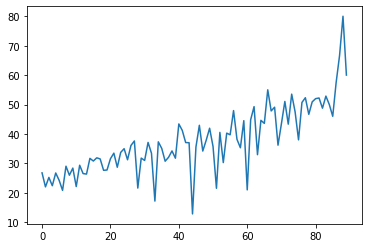

In [ ]:
plt.plot(testing_accuracies)

**Conclusion :** We can notice that the accuracy is increasing with this method by choosing the right set of samples to train on.